# UNDER WATER IMAGE ENHANCEMENT 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
import sys

1024 768


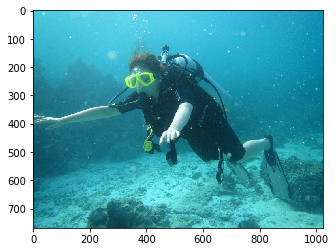

In [2]:
# reading image and its parameters
origImg = cv2.imread('../Raw/6_img_.png')
origImg = cv2.cvtColor(origImg, cv2.COLOR_BGR2RGB)

height = origImg.shape[0]
width = origImg.shape[1]
print(width,height)
plt.imshow(origImg)

### Original red, green and blue channels 

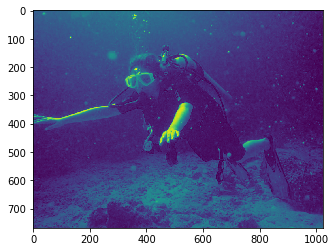

In [3]:
r,g,b = cv2.split(origImg)
plt.imshow(r)
plt.savefig('redOriginal.png',format = "png", dpi = 300)

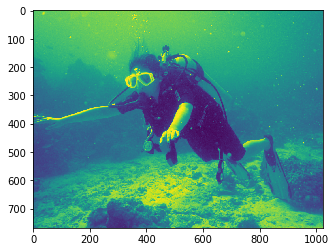

In [4]:
plt.imshow(g)

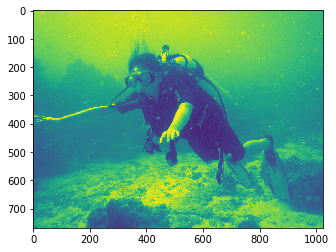

In [5]:
plt.imshow(b)

## White Balancing

In [6]:
#normalising r,g,b to range [0,1]

rW = np.divide(r,255)
gW = np.divide(g,255)
bW = np.divide(b,255)


print("\nmeanRed")
meanRed = np.sum(rW)/rW.size
print(meanRed)

print("\nmeanGreen")
meanGreen = np.sum(gW)/gW.size
print(meanGreen)

print("\nmeanBlue")
meanBlue = np.sum(bW)/bW.size
print(meanBlue)



meanRed
0.17874596290339048

meanGreen
0.575418993382672

meanBlue
0.636279242023144


In [7]:
# compensating red and blue channel

for i in range(height):
    for j in range(width):
        rW[i][j] += (meanGreen - meanRed)*(1-rW[i][j])*gW[i][j]

print(abs(meanBlue-meanGreen))
if(abs(meanBlue-meanGreen) > 0.1):
    for i in range(height):
        for j in range(width):
            bW[i][j] += (meanGreen - meanBlue)*(1-bW[i][j])*gW[i][j]

0.060860248640472014


In [8]:
AfterComp = cv2.merge((rW,gW,bW))

### Compensated red and blue channels

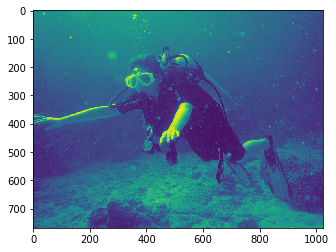

In [9]:
plt.imshow(rW)
plt.savefig('redCompensated.png',format = "png", dpi = 300)

# print(rW)

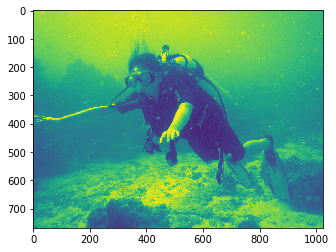

In [10]:
plt.imshow(bW)

### output after red and blue channel compensation 

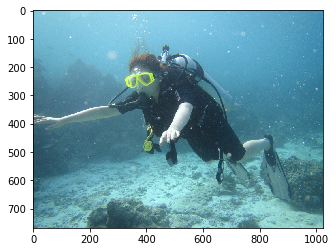

In [11]:
plt.imshow(AfterComp)

In [12]:
def GrayWorld(img,rF,gF,bF):

    # Applying gray world on image

    scale = np.sum(img)/np.size(img)
    print(scale)

    redM = np.sum(rF)/rF.size
    greenM = np.sum(gF)/gF.size
    blueM = np.sum(bF)/bF.size


    rF = np.array(rF)* scale / redM
    gF = np.array(gF)* scale / greenM
    bF = np.array(bF)* scale / blueM

    AfterGrayWorld = cv2.merge((rF,gF,bF))
    
    return AfterGrayWorld

### Gray world on white balanced image 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.523587074101307


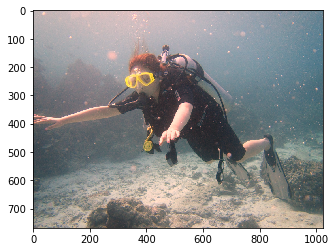

In [13]:
whiteBalanced = GrayWorld(AfterComp,rW,gW,bW)
plt.imshow(whiteBalanced)
plt.savefig('whiteBalance.png',format = "png", dpi = 300)

### Direct gray world output on original input image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.4634813994364021


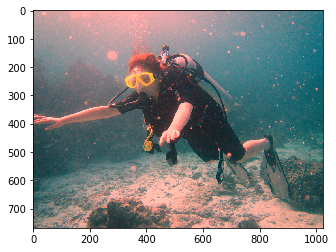

In [14]:
r = np.divide(r,255)
g = np.divide(g,255)
b = np.divide(b,255)

origImg = cv2.merge((r,g,b))
DirectGrayWorld = GrayWorld(origImg,r,g,b)
plt.imshow(DirectGrayWorld)
plt.savefig('DirectGrayWorld.png',format = "png", dpi = 300)

### Gamma correction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


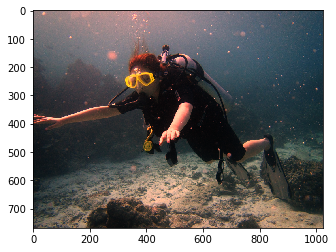

In [15]:
# gamma correction
gamma = 2.0
gammaCorrected = np.copy(whiteBalanced)
for i in range(height):
    for j in range(width):
        gammaCorrected[i][j] = (whiteBalanced[i][j])**gamma
plt.imshow(gammaCorrected)
plt.savefig('gammaCorrected.png',format = "png", dpi = 300)

### Traditional unsharp masking 

In [16]:
# traditional unsharped masking
def tradUnsharpMask(whiteBalanced):
    blur = cv2.GaussianBlur(whiteBalanced,(5,5),0)     # (I*G)
    temp = np.subtract(whiteBalanced,blur)             # (I - I*G)    
    Traditional_unsharp_masking = np.add(whiteBalanced,temp)  # I + (I - I*G)
    return Traditional_unsharp_masking

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


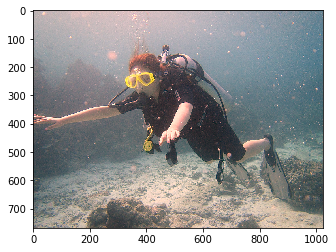

In [17]:
Traditional_unsharp_masking = tradUnsharpMask(whiteBalanced)
plt.imshow(Traditional_unsharp_masking)
plt.savefig('Traditional_unsharp_masked_image.png',format = "png", dpi = 300)

### Normalised unsharp masking 

In [18]:
#histogram stretch
def histogramStretch(channel):
    minval = channel.min()
    maxval = channel.max()
    for i in range(channel.shape[0]):
        for j in range(channel.shape[1]):
            channel[i][j] = (channel[i][j] - minval)/(maxval - minval)
    return channel

In [19]:
# normalised unsharp masking

def NormUnsharpMask(whiteBalanced):
    blur = cv2.GaussianBlur(whiteBalanced,(5,5),0)     # (I*G)
    temp = np.subtract(whiteBalanced,blur)             # (I - I*G)
    
    # histogram stretching    
    red,green,blue = cv2.split(temp)
    red = histogramStretch(red)
    green = histogramStretch(green) 
    blue = histogramStretch(blue)    
       
    tempLinearOperatorzied = cv2.merge((red,green,blue))              # N(I - I*G)
      
    Normalized_unsharp_masking = np.add(whiteBalanced,tempLinearOperatorzied) # I + N(I - I*G)
    Normalized_unsharp_masking =np.divide(Normalized_unsharp_masking,2)      # (I + N(I - I*G))/2
    
    return Normalized_unsharp_masking

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


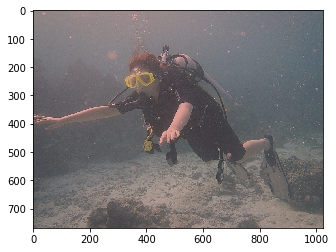

In [20]:
Normalized_unsharp_masked_image = NormUnsharpMask(whiteBalanced)
plt.imshow(Normalized_unsharp_masked_image)
plt.savefig('Normalized_unsharp_masked_image.png',format = "png", dpi = 300)

### Laplacian weight 

In [21]:
def LaplacianContrastWeight(inputImg):
    blur = cv2.GaussianBlur(inputImg,(3,3),0)
    gray = cv2.cvtColor(blur, cv2.COLOR_RGB2GRAY)
    # Apply Laplace function
    ddepth = cv2.cv2.CV_32F
    lap = cv2.Laplacian(gray,ddepth,ksize=3)
    
    lap = np.abs(lap)
    return lap

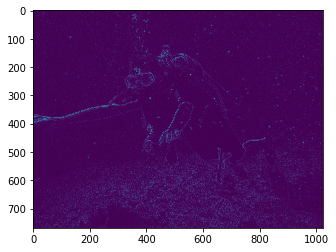

In [22]:
WL1 = LaplacianContrastWeight(gammaCorrected.astype(np.float32))
plt.imshow(WL1)
plt.savefig('LaplacianWeight_1.png',format = "png", dpi = 300)

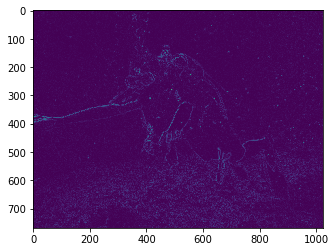

In [23]:
WL2 = LaplacianContrastWeight(Normalized_unsharp_masked_image.astype(np.float32))
plt.imshow(WL2)
plt.savefig('LaplacianWeight_2.png',format = "png", dpi = 300)

###  Saliency weight 

In [24]:
# saliency

def saliency(inputImg):
    
    gray = cv2.cvtColor(inputImg, cv2.COLOR_RGB2GRAY)
        
    blur_filter = [1,4,6,4,1]
    blur_filter = np.matrix(blur_filter)
    blur_filter = np.divide(blur_filter,16.0)
    
    image_blurX = np.zeros((gray.shape))         
  
    image_blurX = cv2.filter2D(gray, -1, blur_filter)
    
    blur_filter = np.transpose(blur_filter)
    
    image_blurY = cv2.filter2D(image_blurX, -1, blur_filter)
    
    
    inputImg = cv2.cvtColor(inputImg, cv2.COLOR_RGB2LAB)
    image_blurY = cv2.cvtColor(image_blurY, cv2.COLOR_GRAY2RGB)
    image_blurY = cv2.cvtColor(image_blurY, cv2.COLOR_RGB2LAB)
    
    #Lab space euclidean distance
    Saliency = np.zeros((inputImg.shape))
    for i in range(inputImg.shape[0]):
        for j in range(inputImg.shape[1]):
            Saliency[i][j][0] = math.sqrt((inputImg[i][j][0] - image_blurY[i][j][0])**2)
            Saliency[i][j][1] = math.sqrt((inputImg[i][j][1] - image_blurY[i][j][1])**2)
            Saliency[i][j][2] = math.sqrt((inputImg[i][j][2] - image_blurY[i][j][2])**2)    
    Saliency = cv2.cvtColor(Saliency.astype(np.float32), cv2.COLOR_LAB2RGB)
    Saliency = cv2.cvtColor(Saliency, cv2.COLOR_RGB2GRAY)

    Saliency = np.abs(Saliency)
    return Saliency

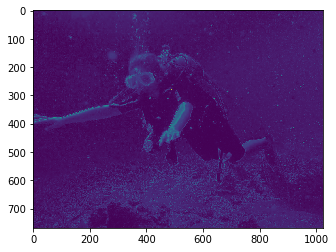

In [25]:
WS1 = saliency(gammaCorrected.astype(np.float32))
plt.imshow(WS1)
plt.savefig('SaliencyWeight_1.png',format = "png", dpi = 300)

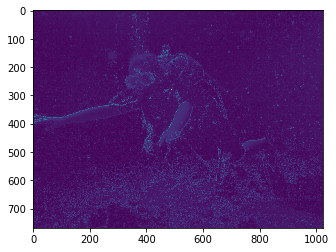

In [26]:
WS2 = saliency(Normalized_unsharp_masked_image.astype(np.float32))
plt.imshow(WS2)
plt.savefig('saliencyWeight_2.png',format = "png", dpi = 300)

### Saturation weight 

In [27]:
def saturation(inputImg):
    R,G,B = cv2.split(inputImg)
    L = cv2.cvtColor(inputImg, cv2.COLOR_RGB2GRAY)
    Wsat = np.zeros((L.shape))
    for i in range(inputImg.shape[0]):
        for j in range(inputImg.shape[1]):
            Wsat[i][j] = math.sqrt(((R[i][j]-L[i][j])**2 + (G[i][j]-L[i][j])**2 + (B[i][j]-L[i][j])**2 )/3)
    Wsat = np.abs(Wsat)
    return Wsat

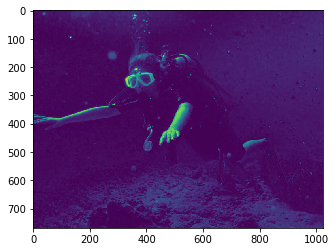

In [28]:
Wsat1 = saturation(gammaCorrected.astype(np.float32))
plt.imshow(Wsat1)
plt.savefig('saturatedWeight_1.png',format = "png", dpi = 300)

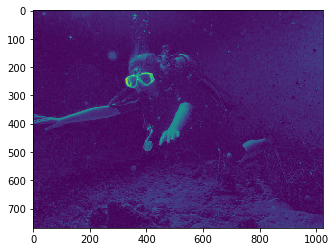

In [29]:
Wsat2 = saturation(Normalized_unsharp_masked_image.astype(np.float32))
plt.imshow(Wsat2)
plt.savefig('saturatedWeight_2.png',format = "png", dpi = 300)

### Aggregated weight map 

In [30]:
Wk1 = np.add(WL1,WS1,Wsat1)
Wk2 = np.add(WL2,WS2,Wsat2)

Wk1t = np.add(Wk1,0.1)
Wk2t = np.add(Wk2,0.2)

Wkall = np.add(Wk1t,Wk2t)

In [31]:
Wk1_ =  np.divide(np.add(Wk1,0.1),Wkall)
Wk2_ =  np.divide(np.add(Wk2,0.1),Wkall)

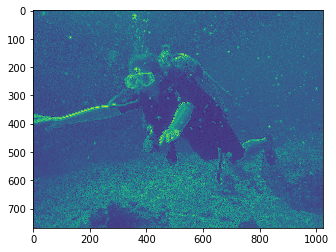

In [32]:
plt.imshow(Wk1_)
plt.savefig('aggregatedWeightMap_1.png',format = "png", dpi = 300)

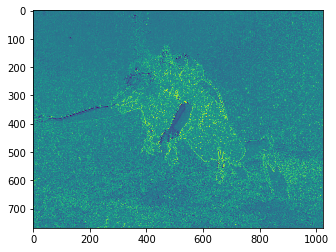

In [33]:
plt.imshow(Wk2_)
plt.savefig('aggregatedWeightMap_2.png',format = "png", dpi = 300)

### Naive Fusion

In [34]:
# Naive fusion
def naiveFusion(Wk1_,Wk2_,gammaCorrected,Normalized_unsharp_masked_image):
    
    # nv =  R(x) = sum(Wk(x)*Ik(x)) 
    nv1 = np.zeros((gammaCorrected.shape))
    for i in range(gammaCorrected.shape[0]):
        for j in range(gammaCorrected.shape[1]):
            nv1[i][j][0] = gammaCorrected[i][j][0] * Wk1_[i][j]
            nv1[i][j][1] = gammaCorrected[i][j][1] * Wk1_[i][j] 
            nv1[i][j][2] = gammaCorrected[i][j][2] * Wk1_[i][j]
     
    nv2 = np.zeros((Normalized_unsharp_masked_image.shape))
    for i in range(Normalized_unsharp_masked_image.shape[0]):
        for j in range(Normalized_unsharp_masked_image.shape[1]):
            nv2[i][j][0] = Normalized_unsharp_masked_image[i][j][0] * Wk2_[i][j]
            nv2[i][j][1] = Normalized_unsharp_masked_image[i][j][1] * Wk2_[i][j] 
            nv2[i][j][2] = Normalized_unsharp_masked_image[i][j][2] * Wk2_[i][j]                
    
    nv = np.add(nv1,nv2)
    plt.imshow(nv)
    plt.savefig('NaiveFusion.png',format = "png", dpi = 300)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


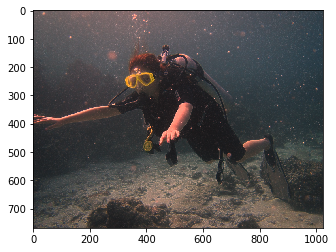

In [35]:
naiveFusion(Wk1_,Wk2_,gammaCorrected,Normalized_unsharp_masked_image)

## Multi-scale fusion 

In [36]:
# multiscale fusion

def multiscaleFusion(Ik,Wk_,levels):
    Rk = np.zeros((Ik.shape))
    LIk = np.zeros((Ik.shape))     #Laplacian L(I) at level l (L1 {I(x)}+ L2 {I(x)}+ G2 {I (x)})
    origW = Ik.shape[1]
    origH = Ik.shape[0]

     
    for i in range(levels):
        w = int(origW/(2**(i)))
        h = int(origH/(2**(i)))
        
        Ik = cv2.resize(Ik, dsize=(w, h), interpolation=cv2.INTER_CUBIC)     # downsample Input image
        Wk_ = cv2.resize(Wk_, dsize=(w, h), interpolation=cv2.INTER_CUBIC)     # downsample corresponding weight
        
        GIk = cv2.GaussianBlur(Ik,(3,3),0)
        LIktemp = np.subtract(Ik,GIk)        #(L = I - GI)
        
        GWk_ = cv2.GaussianBlur(Wk_,(3,3),0)
               
        w = origW
        h = origH
        
        Ik = GIk                 # decimated image as input to next level
        Wk_ = GWk_
             
        LIktemp  = cv2.resize(LIktemp, dsize=(w, h), interpolation=cv2.INTER_CUBIC)     # upsample LIktemp
        GWk_ = cv2.resize(GWk_, dsize=(w, h), interpolation=cv2.INTER_CUBIC)     # upsample GWk_
        GIk = cv2.resize(GIk, dsize=(w, h), interpolation=cv2.INTER_CUBIC)     # upsample GIk
        
        if(i<level-1):
            LIk  = np.add(LIk,LIktemp)
        else:
            LIk  = np.add(LIk,GIk)          # GIk for last level (L(I) at level l =  L1 {I(x)}+ L2 {I(x)}+ G2 {I (x)})


        temp = np.zeros((Rk.shape))
        for i in range(Rk.shape[0]):
            for j in range(Rk.shape[1]):
                temp[i][j][0] = LIk[i][j][0] * GWk_[i][j]
                temp[i][j][1] = LIk[i][j][1] * GWk_[i][j] 
                temp[i][j][2] = LIk[i][j][2] * GWk_[i][j]

        Rk = np.add(Rk,temp)
        
    return Rk
        

In [45]:
minval = min(gammaCorrected.shape[1],gammaCorrected.shape[0])
level = round(math.log(minval/50))      # thresholding the level to 50 pixel min. value(decimated image size)
Rk1 = multiscaleFusion(gammaCorrected,Wk1_,level)
level = round(math.log(minval/50))
Rk2 = multiscaleFusion(Normalized_unsharp_masked_image,Wk2_,level)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


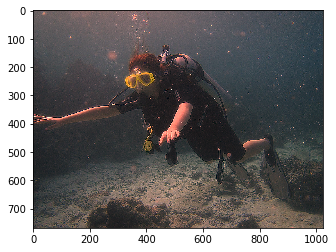

In [46]:
MultiscaleFusion = np.add(Rk1,Rk2)
plt.imshow(MultiscaleFusion)
plt.savefig('MultiscaleFusion.png',format = "png", dpi = 300)